In [1]:
%env HSA_OVERRIDE_GFX_VERSION="10.3.1 python"
import torch
from torch.autograd import Variable as V
from torchvision.io import read_image
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.spatial.transform import Rotation as R

env: HSA_OVERRIDE_GFX_VERSION="10.3.1 python"


In [2]:
torch.autograd.set_detect_anomaly(False)  # use to detect nans (SLOW!!)

if torch.cuda.is_available():
    device = torch.device("cuda")  # works for ROCm too
    print('cuda devices:', torch.cuda.device_count())
    for i in range(torch.cuda.device_count()):
        print(f'\t{torch.cuda.get_device_properties(i).name}')
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
# device = torch.device("cpu")
torch.set_default_device(device)
dtype = torch.float
torch.set_default_dtype(dtype)

In [3]:
class Camera:
    def __init__(self, pos, u, v, w, focal_length, size, render_distance, resolution):
        self.pos = pos.float().to(device)
        # orthonormal basis for camera POV
        self.u = u  # left
        self.v = v  # up
        self.w = w  # forward (viewing direction)
        self.d = focal_length  # distance from pos to pixels
        self.size = size
        self.max_dist = render_distance;
        self.res = resolution

    def pixel_pos(self, i, j):
        width, height = self.res
        w_ratio = width / max(width, height)
        h_ratio = height / max(width, height)
        if i < 0 or j < 0 or i >= width or j >= height:
            raise IndexError('Pixel out of bounds')
        return self.pos + self.d * self.w \
                        + w_ratio * self.size / 2 * (i / width - 0.5) * self.u \
                        + h_ratio * self.size / 2 * (j / height - 0.5) * self.v

    def pixel_dir(self, i, j):
        dir = self.pixel_pos(i, j) - self.pos
        return dir / dir.norm()

    def all_pixel_dirs(self):
        width, height = self.res
        dirs = torch.zeros((width, height, 3), device=device)
        for i in range(width):
            for j in range(height):
                dirs[i, j, :] = self.pixel_dir(i, j)
        return dirs

    def origins(self):
        width, height = self.res
        return torch.tile(self.pos, (width, height, 1)).to(device)


In [4]:
class BlenderDefaultCamera(Camera):
    def __init__(self, pos, u, v, w, res):
        super().__init__(pos, u, v, w, 0.005, 0.036, 50, res)

class BlenderOrbitCamera(BlenderDefaultCamera):
    def __init__(self, pos, res):
        u, v, w = camera_dir_from_pos(pos)
        super().__init__(pos, u, v, w, res)

In [5]:
def camera_dir_from_pos(pos):
    x, y, z = pos
    x_angle = np.pi / 2 - torch.arctan2(z, torch.sqrt(x ** 2 + y ** 2))
    z_angle = np.pi / 2 + torch.arctan2(y, x)
    rotation = R.from_euler('xyz', [x_angle, 0, z_angle])
    M = torch.from_numpy(rotation.as_matrix()).float()
    return (M[:, 0], M[:, 1], M[:, 2])

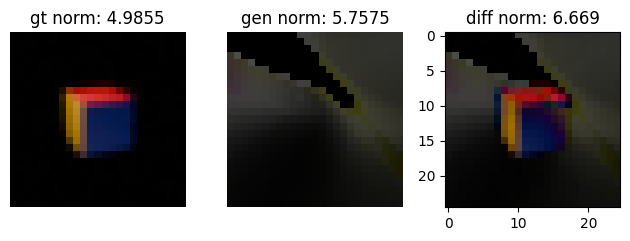

In [7]:
class NeRF(torch.nn.Module):
    def __init__(self, training_dir, res, samples_per_ray, layer_size=8):
        super().__init__()
        self.layer_size = layer_size
        self.d1 = torch.nn.Sequential(
            torch.nn.Linear(3, layer_size),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(layer_size, layer_size),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(layer_size, layer_size),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(layer_size, layer_size),
            torch.nn.LeakyReLU()
        )
        self.d2 = torch.nn.Sequential(
            torch.nn.Linear(layer_size + 3, layer_size),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(layer_size, layer_size),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(layer_size, layer_size),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(layer_size, 4)
        )

        self.dir = training_dir
        self.camera_positions = torch.from_numpy(np.genfromtxt(f'{self.dir}/coords.csv', delimiter=',')).float()
        self.res = res
        self.samples_per_ray = samples_per_ray


    def get_camera_for_pos(self, i):
        return BlenderOrbitCamera(self.camera_positions[i, :], self.res)


    def forward(self, x, dirs):
        curr = self.d1(x)
        curr = torch.cat((curr, x), dim=2)
        curr = self.d2(curr)
        density = torch.nn.functional.relu(curr[:, :, 0].unsqueeze(2))
        colour = torch.sigmoid(curr[:, :, 1:])
        return density, colour


    def render(self, camera):
        width, height = self.res
        
        h = camera.max_dist / self.samples_per_ray
        origins = camera.origins()
        dirs = camera.all_pixel_dirs()
        
        density_so_far = torch.zeros((width, height, 1), device=device, requires_grad=True)
        pixels = torch.zeros((width, height, 3), device=device, requires_grad=True)

        prev_t = 0
        for s in torch.arange(0, camera.max_dist, h):
            t = s + torch.rand((1,)) * h
            # t = s
            x = origins + t * dirs * 10000

            # HERE -------------------------------
            density, colour = self(x, dirs)
            # HERE -------------------------------

            delta = (t - prev_t)

            
            # print(colour)

            density_so_far = density_so_far + delta * density
            T = torch.exp(-density_so_far)
            alpha = 1 - torch.exp(-delta * density)

            pixels = pixels + T * alpha * colour
            
            prev_t = t

        return pixels.reshape((width, height, 3))

    
    def get_params_norm(self):
        s = 0
        for param in self.parameters():
            s += param.norm().item()
        return s


    def get_grad_norm(self):
        s = 0
        for param in self.parameters():
            s += param.grad.norm().item()
        return s

    
    def get_training_image(self, i):
        return read_image(f'{self.dir}/{i}.png')[:3,:].permute(1, 2, 0).float() / 255


    def render_example(self, i):
        cam = BlenderOrbitCamera(self.camera_positions[i, :], self.res)
        return self.render(cam)


    def view_example(self, i):
        rgb_img_torch = self.render_example(i)
        rgb_img_torch = rgb_img_torch / rgb_img_torch.max()
        # rgb_img_torch = torch.softmax(rgb_img_torch, axis=2)
        # print(rgb_img_torch)
        rgb_img_cpu = rgb_img_torch.cpu().detach().numpy()
        plt.axis('off')
        plt.imshow(rgb_img_cpu)

    
    def plot_example(self, i):
        gt_img = self.get_training_image(i).detach().numpy()
        gen_img = self.render_example(i).detach().numpy()
        
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        ax1.axis('off')
        ax2.axis('off')
        ax1.imshow(gt_img)
        ax1.set_title(f'gt norm: {np.linalg.norm(gt_img):3.5}')
        ax2.imshow(gen_img)
        ax2.set_title(f'gen norm: {np.linalg.norm(gen_img):3.5}')
        ax3.imshow(np.abs(gen_img - gt_img))
        ax3.set_title(f'diff norm: {np.linalg.norm(gen_img - gt_img):3.5}')
        fig.tight_layout()
        # fig.show()


    def train(self, num_epochs=25, lr=0.001, block_size=None):
        N, _ = self.camera_positions.size()
        if block_size == None:
            block_size = N
        for k in range(num_epochs):
            print(f'\nepoch {k+1:>3}/{num_epochs} ----------------')
            for j in range(N // block_size):
                s = 0
                self.zero_grad()
                for i in range(j * block_size, min((j + 1) * block_size, N)):
                    gt_img = self.get_training_image(i).to(device)
                    gen_img = self.render_example(i)
                    loss = (gt_img - gen_img).norm() ** 2 / block_size
                    loss.backward()
                    s += loss.item()
                for param in self.parameters():
                    param.data -= param.grad * lr
                print(f'\tblock {j+1:>3}/{N // block_size} loss: {s}')
            # self.plot_example(torch.randint(low=0, high=N, size=(1,)).item())

    
    def test_loss(self, camera):
        origins = V(camera.origins(), requires_grad=True)
        dirs = V(camera.all_pixel_dirs(), requires_grad=True)
        d = torch.zeros((1,), device=device)

        print(origins.is_leaf, dirs.is_leaf, d.is_leaf) # True True True
        
        density, colour = self(origins, dirs)
        self.zero_grad()
        colour[0, 0, 0].backward(retain_graph=True)
        c = 0
        for name, p in self.named_parameters():
            print(f'{c:>3} {name:>10}', end='')
            print(f'\t grad: {p.grad.norm():>2.5}\t{p.requires_grad}')
            c += 1


rrr = 25
spr = 100
model = NeRF(f'./cube_{rrr}x{rrr}', (rrr, rrr), spr)
# model.test_loss(model.get_camera_for_pos(0))
model.plot_example(1)


epoch   1/25 ----------------
	block   1/1 loss: 89.03754970431328

epoch   2/25 ----------------
	block   1/1 loss: 35.697542034089565

epoch   3/25 ----------------
	block   1/1 loss: 35.58581713587046

epoch   4/25 ----------------
	block   1/1 loss: 35.537153482437134

epoch   5/25 ----------------
	block   1/1 loss: 35.63190944865346

epoch   6/25 ----------------
	block   1/1 loss: 35.50443988293409

epoch   7/25 ----------------
	block   1/1 loss: 35.71823089197278

epoch   8/25 ----------------
	block   1/1 loss: 35.65905869752169

epoch   9/25 ----------------
	block   1/1 loss: 35.439807903021574

epoch  10/25 ----------------
	block   1/1 loss: 35.62652866542339

epoch  11/25 ----------------
	block   1/1 loss: 35.77520141378045

epoch  12/25 ----------------
	block   1/1 loss: 35.50643499195576

epoch  13/25 ----------------
	block   1/1 loss: 35.50609818845987

epoch  14/25 ----------------
	block   1/1 loss: 35.47962574660778

epoch  15/25 ----------------
	block   1/1 l

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

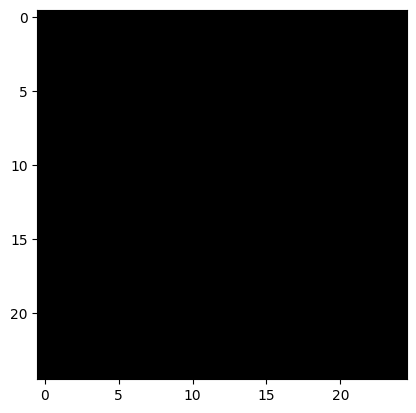

In [8]:
model = NeRF(f'./cube_{rrr}x{rrr}', (rrr, rrr), spr)
model.train(lr=0.01, num_epochs=25)
e = model.render_example(7).detach().numpy()
if e.max() != 0:
    e /= e.max()
plt.imshow(e)
e[:,:,0]

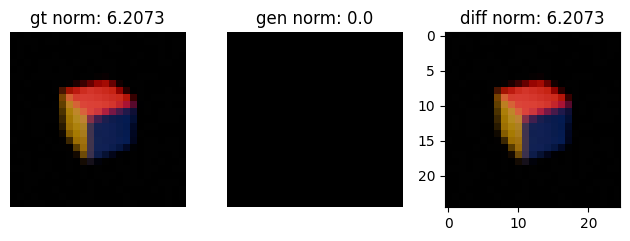

In [9]:
model.plot_example(25)

In [ ]:
# plt.imshow(model.get_training_image(1)[:,:,2])
plt.imshow(e[:,:,1])
plt.colorbar()

In [ ]:
# model = NeRF(f'./cube_{rrr}x{rrr}', (rrr, rrr), spr)
N, _ = model.camera_positions.size()
num_epochs = 25
block_size = N
lr = 0.001

iii = 0
ys = []

for k in range(num_epochs):
    print(f'\nepoch {k+1:>3}/{num_epochs} ----------------')
    for j in range(N // block_size):
        s = 0
        model.zero_grad()
        for i in range(j * block_size, min((j + 1) * block_size, N)):
            gt_img = model.get_training_image(i).to(device)
            gen_img = model.render_example(i)
            loss = (gt_img - gen_img).norm() ** 2 / block_size
            loss.backward()
            s += loss.item()

        for param in model.parameters():
            param.data -= param.grad * lr
        ys.append(model.get_grad_norm())
        iii += 1
        print(f'\tblock {j+1:>3}/{N // block_size} loss: {s:>3.5} grad: {model.get_grad_norm():>3.5}')

plt.plot(np.arange(iii), ys)

In [ ]:
plt.plot(np.arange(iii), ys)

In [ ]:
model.train(lr=1, block_size=20, num_epochs=10)
e = model.render_example(7).detach().numpy()
plt.imshow(e / e.max())
e

In [ ]:
model.train(num_epochs=10, lr=1)
e = model.render_example(7).detach().numpy()
plt.imshow(e / e.max())
e

In [ ]:
e = model.render_example(7).detach().numpy()
plt.imshow(e / e.max())
e

In [52]:
gt_img = model.get_training_image(10).to(device)
gt_img.size()
gt_img.detach().numpy()

array([[[0.00392157, 0.00392157, 0.00392157],
        [0.        , 0.        , 0.        ],
        [0.00392157, 0.00392157, 0.00392157],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.00392157, 0.00392157, 0.00392157],
        [0.00392157, 0.00392157, 0.00392157],
        ...,
        [0.        , 0.        , 0.        ],
        [0.00392157, 0.00392157, 0.00392157],
        [0.00392157, 0.00392157, 0.00392157]],

       [[0.        , 0.        , 0.        ],
        [0.00392157, 0.00392157, 0.00392157],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.00392157, 0.00392157, 0.00392157],
        [0.00392157, 0.00392157, 0.00392157]],

       ...,

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.00392157, 0

In [50]:
gen_img = model.render_example(10)
gen_img.size()

torch.Size([25, 25, 3])